In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [364]:
csv_url = "https://raw.githubusercontent.com/ITACADEMYprojectes/projecteML/main/bank_dataset.CSV"
df = pd.read_csv(csv_url)

## Informació general, primeres files i sumari estadístic

In [366]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


,age,balance,day,duration,campaign,pdays,previous
count,11152.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.235384,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.914934,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Histogrames per les variables numèriques

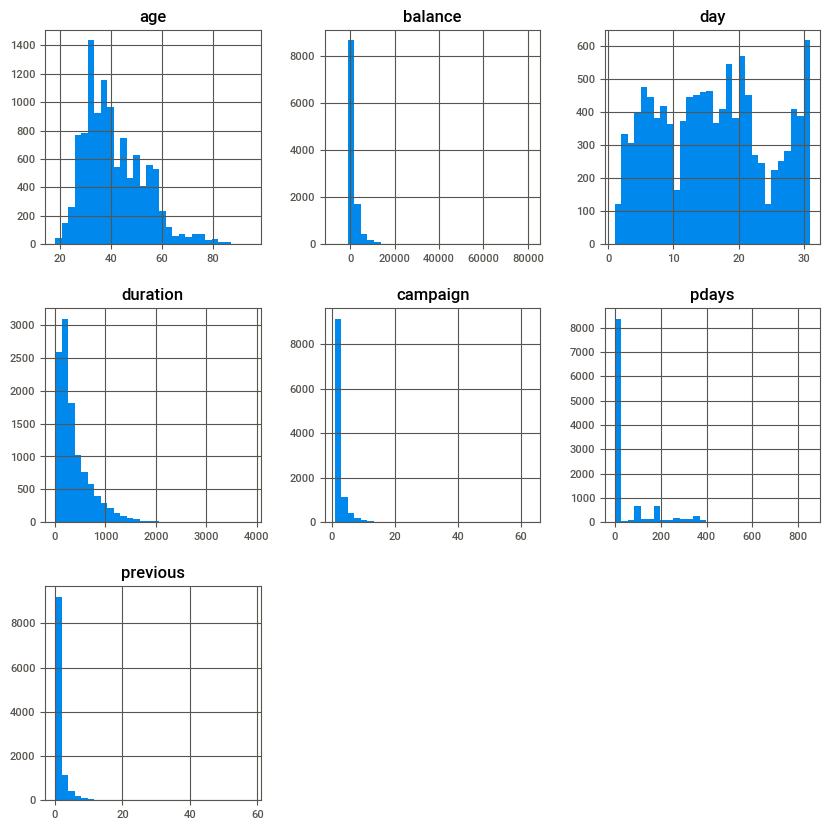

In [368]:
vars_con = [1,5,9,11,12,13,14]
vars_fac = [2,3,4,6,7,8,10,15,16]
df.hist(bins=30, figsize=(10, 10))
plt.show()

## Boxplot per detecció d'outliers univariants en les variables numèriques

No és gaire informatiu doncs les escales són molt diferents. 

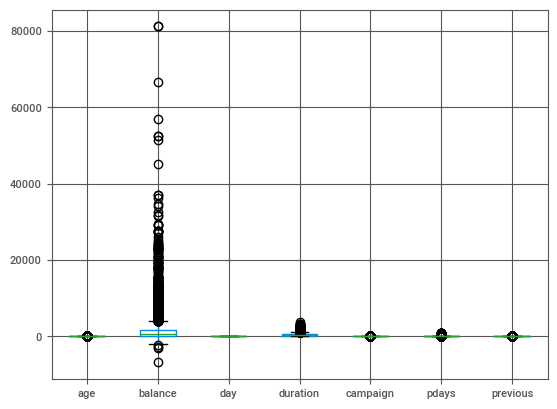

In [370]:
df.boxplot()
plt.show()

## Tractament d'outliers

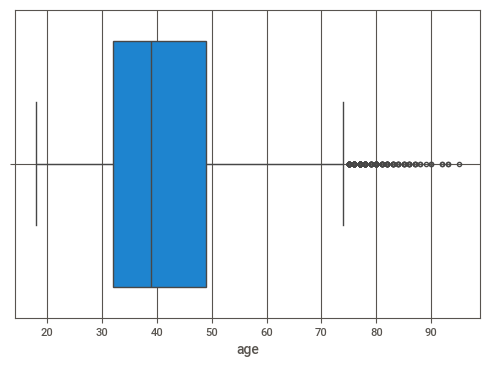

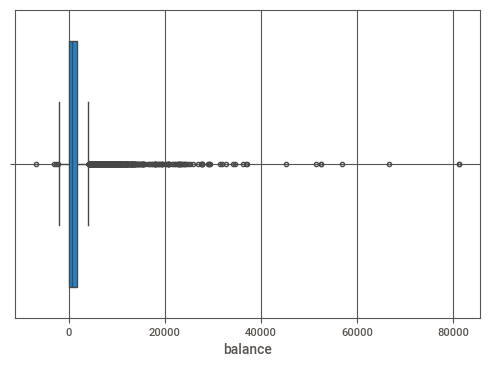

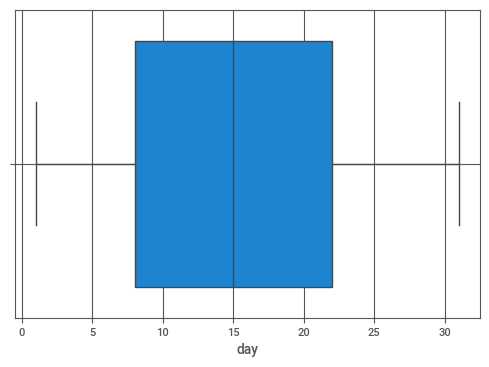

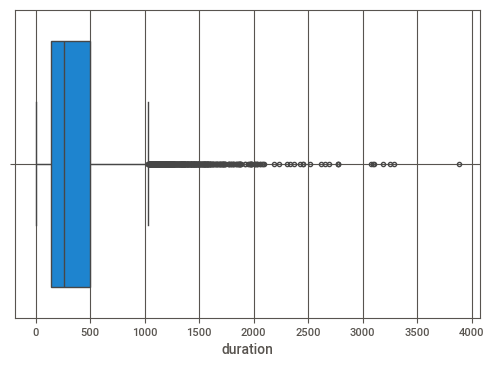

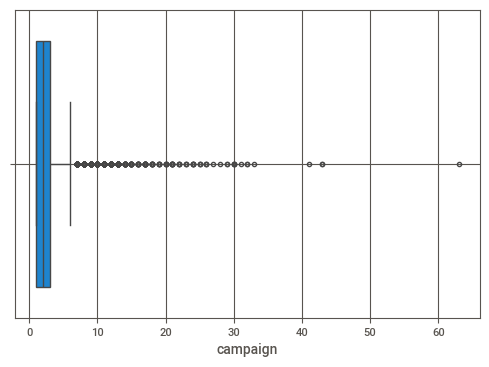

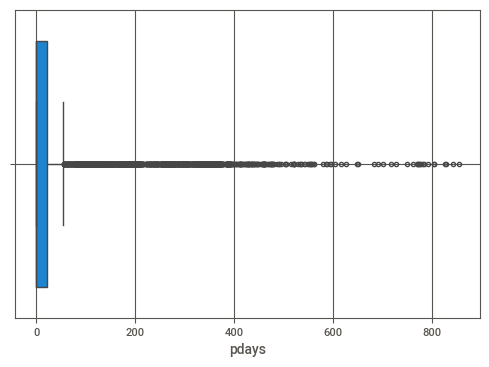

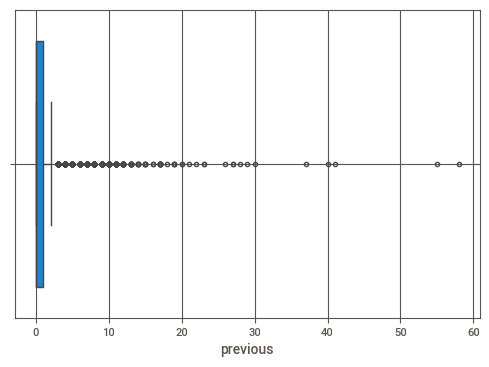

In [372]:
colsnum = df.select_dtypes(include=["number"]).columns.tolist()
for column in colsnum:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # No se detectan outliers

### Anàlisi una a una de les variables numèriques per detectar outliers
Després d'examinar el boxplot i calcular les fites superiors als outliers suaus i severs decideixo no intervenir: els outliers d'age són correctes, raonables i no cal intervenció en aquest punt, potser desestimar les persones més grans de 80 anys en la modelització (dificultats de comprensió dels productes finances, jo crec que majorment no n'estan interessats).

32.0
49.0
IQR 17.0
Llindar superior outliers suaus 74.5
Llindar superior outliers severs 100.0


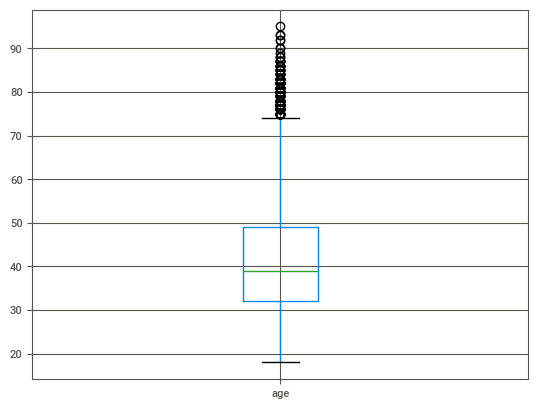

In [374]:
p = df.boxplot(column=['age'], return_type='axes')
p.plot()
print( df['age'].quantile(0.25))
print( df['age'].quantile(0.75)) 

# 50% de la població està entre 32 i 49
# Llindars per outliers suaus
# print(np.min(edat), np.quantile(edat, 0.25), np.median(edat), np.quantile(edat, 0.75), np.max(edat))
iqr = df['age'].quantile(0.75)-df['age'].quantile(0.25)
print("IQR",iqr)
upthr = df['age'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
print("Llindar superior outliers severs",df['age'].quantile(0.75)+3*iqr)
# Per ara no cal tractar els outliers d'age

#### Balance
Distribució extrema, tipus Pareto, per tant els outliers són consustancials, però a partir de 40000 caldria suprimir les observacions 
o millor imputar-les a la mediana. Quines són?. Hi ha outliers severs inferiors que tractaré imputant a -4636 (llindar d'outlier sever inferior). Per tant, és com aplicar una Winzorització a mida.


Llindar superior outliers suaus 4087.0
Llindar superior outliers severs 6466.0
Llindar inferior outliers severs -4636.0


-6847

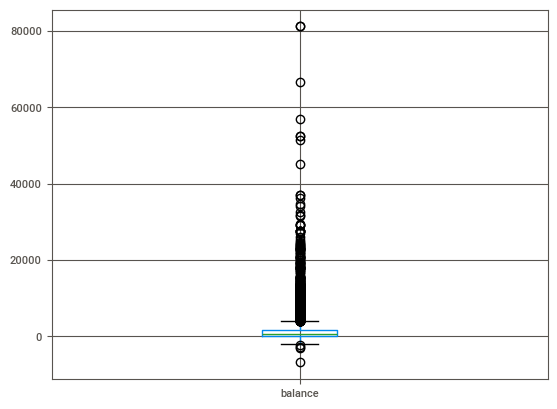

In [376]:
p = df.boxplot(column=['balance'], return_type='axes')
p.plot()
# 50% de la població està entre 32 i 49
# Llindars per outliers suaus
iqr = df['balance'].quantile(0.75)-df['balance'].quantile(0.25)
iqr
upthr = df['balance'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df['balance'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
lothr = df['balance'].quantile(0.25)-3*iqr
print("Llindar inferior outliers severs",lothr)
df['balance'].min()

[]

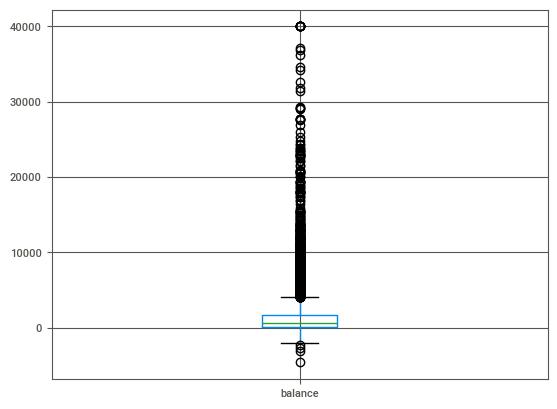

In [377]:
cols = ['balance']
df.loc[df['balance'] > 40000, cols] = 40000
df.loc[df['balance'] < -4636, cols] = -4636
# print( df.isnull().sum())
#df['balance'] = df['balance'].fillna(df['balance'].median())
p = df.boxplot(column=['balance'], return_type='axes')
p.plot()

#### Day
Cap problema com era d'esperar a day

Llindar superior outliers suaus 43.0
Llindar superior outliers severs 64.0


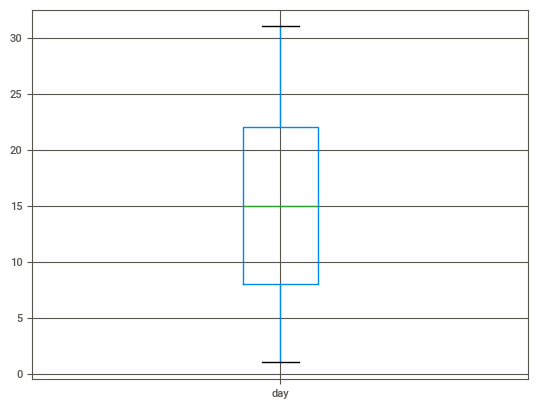

In [379]:
p = df.boxplot(column=['day'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df['day'].quantile(0.75)-df['day'].quantile(0.25)
iqr
upthr = df['day'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df['day'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
# 

#### Duration
Torna a tenir una caiguda exponencial, però hi ha molts zeros, per ara imputo els outliers extrems superiors a 2000

Llindar superior outliers suaus 1033.0
Llindar superior outliers severs 1570.0


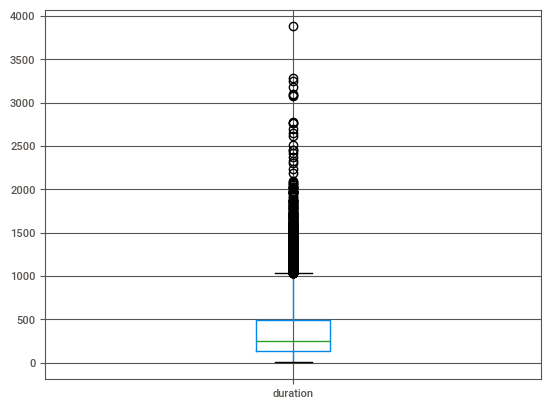

In [381]:
p = df.boxplot(column=['duration'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df['duration'].quantile(0.75)-df['duration'].quantile(0.25)
iqr
upthr = df['duration'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df['duration'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)

[]

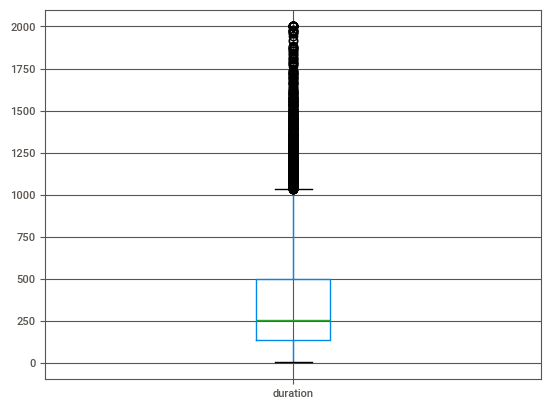

In [382]:
cols = ['duration']
df.loc[df['duration'] > 2000, cols] = 2000

p = df.boxplot(column=['duration'], return_type='axes')
p.plot()

# Resolt comentari 1 del feedback T6.1

#### Previous
Torna a tenir una caiguda exponencial, però hi ha molts zeros, els outliers extrems superiors els imputo a 30

Llindar superior outliers suaus 8.5
Llindar superior outliers severs 13.0


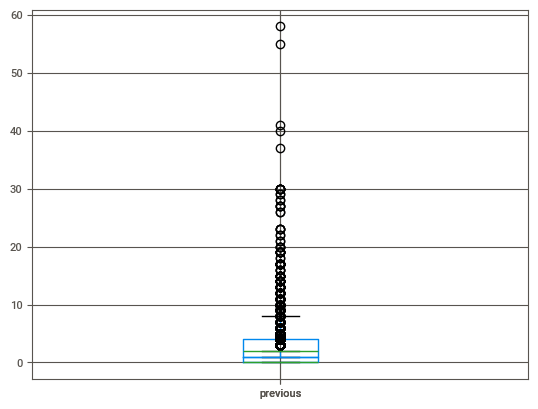

In [384]:
#p = df.boxplot(column=['previous'], return_type='axes')
#p.plot()
cols = ['previous']
df1 = df.loc[df['previous'] >0, cols]
p = df1.boxplot(column=['previous'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df1['previous'].quantile(0.75)-df1['previous'].quantile(0.25)
iqr
upthr = df1['previous'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df1['previous'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
df.loc[df['previous'] > 30, cols] = 30
p = df.boxplot(column=['previous'], return_type='axes')
# Torna a tenir una cua superior, per ara no pup.plot()c prendre una decisió de qué fer

#### Pdays
*Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)*

Torna a tenir una caiguda exponencial, però hi ha molts -1 dels qui no han participat en campanyes anteriors, per ara filtro les observacions dels qui han participat en alguna campanya anterior i els outliers extrems superiors els deixo com estan, per ara.

Llindar superior outliers suaus 568.0
Llindar superior outliers severs 850.0


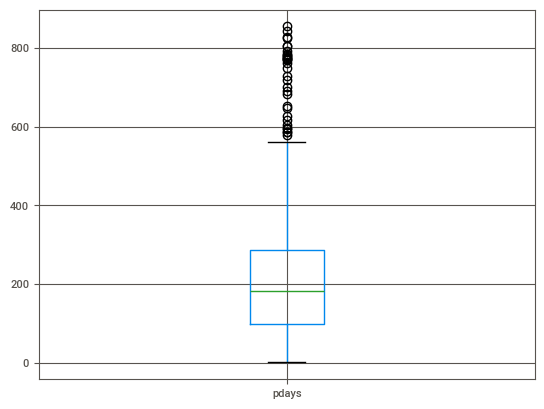

In [386]:
# Delicat, hi ha observacions -1
cols = ['pdays']
df1 = df.loc[df['pdays'] >-1, cols]
p = df1.boxplot(column=['pdays'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df1['pdays'].quantile(0.75)-df1['pdays'].quantile(0.25)
iqr
upthr = df1['pdays'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df1['pdays'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
# No cal fer res

# Campaign
*Number of contacts performed during this campaign and for this client (numeric, includes last contact)*

Torna a tenir una caiguda exponencial, però hi ha molts 0 dels qui no han estat localitzats a la campanya, per ara filtro les observacions dels qui no han participat en la campanya actual i els outliers extrems superiors (superiors a 10) d'aquest subconjunt els imputo a 10 (és a dir, semblant a una winzorització).

Llindar superior outliers suaus 6.0
Llindar superior outliers severs 9.0


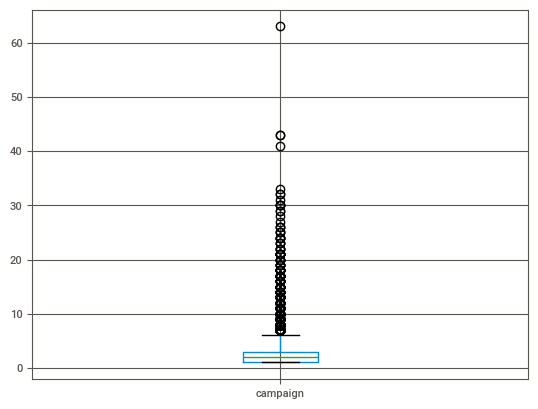

In [388]:
# Delicat, hi ha observacions 0
cols = ['campaign']
df1 = df.loc[df['campaign'] >0, cols]
p = df1.boxplot(column=['campaign'], return_type='axes')
p.plot()
# Llindars per outliers suaus
iqr = df1['campaign'].quantile(0.75)-df1['campaign'].quantile(0.25)
iqr
upthr = df1['campaign'].quantile(0.75)+1.5*iqr
print("Llindar superior outliers suaus",upthr)
upthr = df1['campaign'].quantile(0.75)+3*iqr
print("Llindar superior outliers severs",upthr)
# No cal fer res

[]

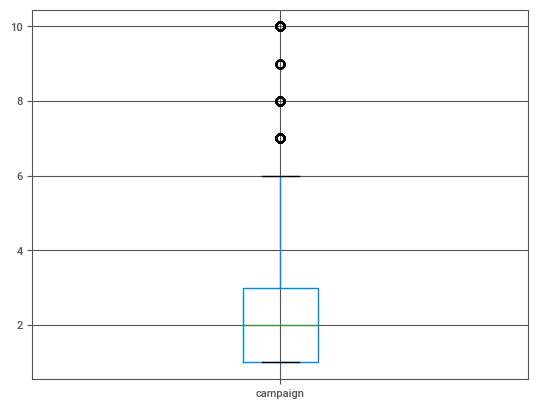

In [389]:
cols = ['campaign']
df.loc[df['campaign'] > 10, cols] = 10
p = df.boxplot(column=['campaign'], return_type='axes')
p.plot()

## Comptar les categories dels factors

Massa categories en el factor job, caldrà reagrupar-les molt possiblement. Per altra banda, tots els factors amb nivell unknown i poques observacions 'unknown' cal resseguir-les, donarà problemes en la modelització (regressió logística).

**Cal remarcar que el target diposit està balancejat (Yes/No)**

In [391]:
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
marital
married     6349
single      3517
divorced    1291
Name: count, dtype: int64
education
secondary    5474
tertiary     3685
primary      1500
unknown       496
Name: count, dtype: int64
default
no     10994
yes      168
Name: count, dtype: int64
housing
no     5881
yes    5281
Name: count, dtype: int64
loan
no     9702
yes    1460
Name: count, dtype: int64
contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64
month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64
poutcome
unknown    8326
failure    1228
success    1071
other       537
Nam

## Visualització valors nuls
No es veu res, per tant millor comptar-los

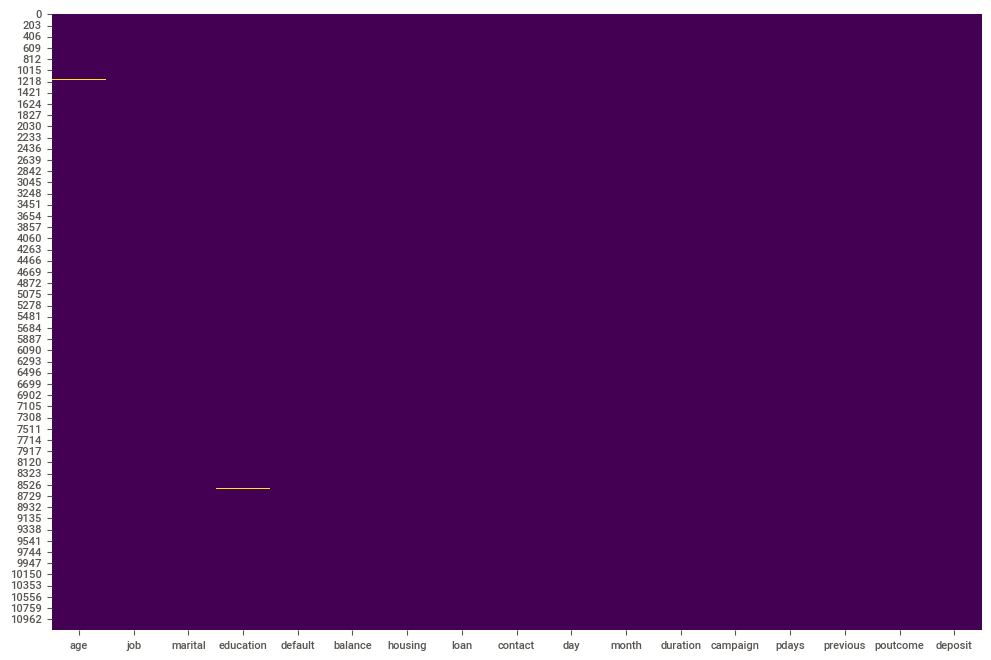

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [393]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()
df.isnull().sum()

## Dades faltants
    -Marital té 3 categories i 5 missings, per tant caldria una categoria "unknown". 
    -Education té 10 missings i ja té definida la categoria "unknown", per tant cal assignar aquesta categoria.
    -Age té 10 missings, es podria fer una imputació amb la mediana doncs no sé com fer imputacions més intel.ligents amb Python.

In [395]:
df['age'] = df['age'].fillna(df['age'].median())
df['education'] = df['education'].fillna('unknown')
df['marital'] = df['marital'].fillna('unknown')
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

# Anàlisi Exploratòria univariant automatitzada amb Sweetviz

**Impresionant**

In [397]:
import sweetviz as sv
report = sv.analyze(df)
report.show_html('EDA_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En aquest punt m'interessa perfilar la relació de les variables numèriques amb el target deposit, ara bé, això està fet al report pels factors (basat en el que diuen un index d'incertesa, m'hauria agradat més veure un pvalor del test chi quadrat entre deposit i cadascun dels factors). No hi ha problemes de colinealitat:

    -poutcome 0.07
    -month 0.07
    -contact 0.05
    -housing 0.03
    -job 0.02
    -loan 0.01
    -education 0.01
    -marital 0.01
    -default 0.00

I per les numèriques es pot extreure també una associació (en diu correlació, incorrecte el terme, m'agradaria veure el pvalor d'un test no paramètric tipus Kruskal-Wallis amb variable continua segons factor dipòsit o un Wilcoxon doncs té dos nivells el target que en Python és Mann-Whitney U rank test per 2 mostres independents).

    -duration 0.45
    -pdays 0.15
    -previous 0.14
    -campaign 0.13
    -balance 0.08
    -day 0.06 (aquesta variable no té sentit usar-la directament)
    -age 0.04



## Associació bivariant entre target deposit i numèriques
### pdays

Valoro no considerar-la en el model

MannwhitneyuResult(statistic=array([18454802.]), pvalue=array([6.23493583e-112]))


<Axes: xlabel='deposit', ylabel='pdays'>

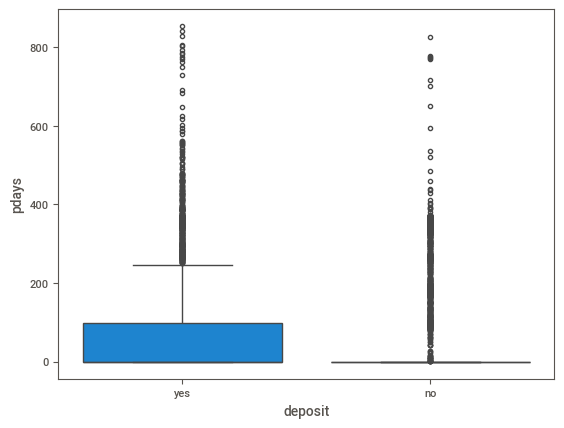

In [400]:
# Defining data groups
from scipy import stats
cols = ['pdays']
df1 = df.loc[df['deposit'] =='yes', cols]
df2 = df.loc[df['deposit'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de pdays a cada categoria de deposit

# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['pdays'], 
            hue = df['deposit'])


### previous
Valoro no considerar-la en el model

MannwhitneyuResult(statistic=array([18687528.]), pvalue=array([2.5996891e-130]))


<Axes: xlabel='deposit', ylabel='previous'>

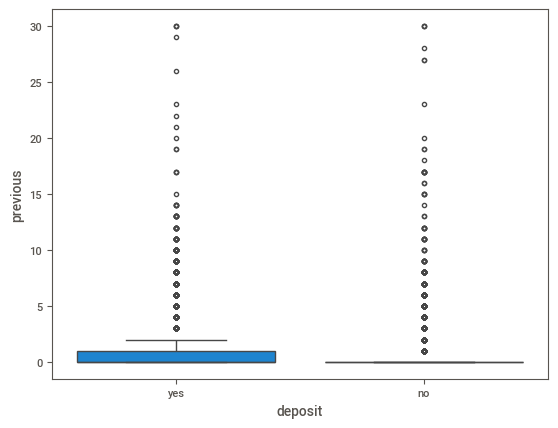

In [402]:
# Defining data groups
from scipy import stats
cols = ['previous']
df1 = df.loc[df['deposit'] =='yes', cols]
df2 = df.loc[df['deposit'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de previous a cada categoria de deposit
# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['previous'], 
            hue = df['deposit'])


### balance
Valoro  considerar-la en el model, aquí vec diferències no degudes als outliers

MannwhitneyuResult(statistic=array([nan]), pvalue=array([nan]))


<Axes: xlabel='deposit', ylabel='balance'>

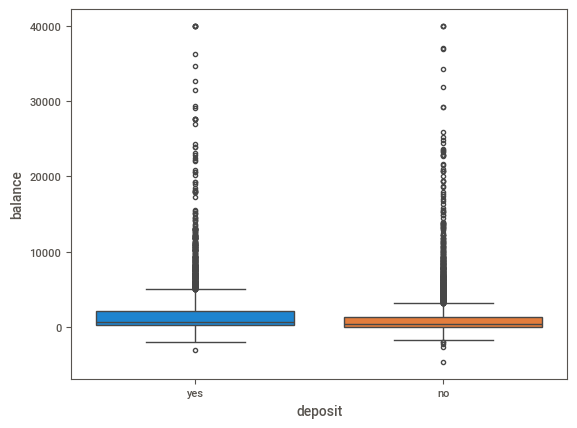

In [404]:
# Defining data groups
from scipy import stats
cols = ['balance']
df1 = df.loc[df['balance'] =='yes', cols]
df2 = df.loc[df['balance'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de previous a cada categoria de deposit
# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['balance'], 
            hue = df['deposit'])


### age
Valoro  considerar-la en el model, aquí vec diferències en les edats avançades

MannwhitneyuResult(statistic=array([nan]), pvalue=array([nan]))


<Axes: xlabel='deposit', ylabel='age'>

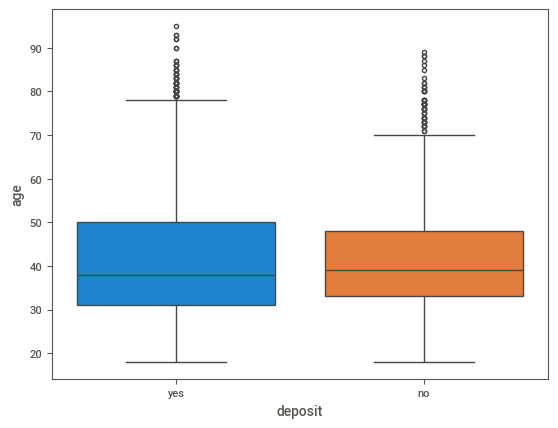

In [406]:
# Defining data groups
from scipy import stats
cols = ['age']
df1 = df.loc[df['age'] =='yes', cols]
df2 = df.loc[df['age'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de previous a cada categoria de deposit
# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['age'], 
            hue = df['deposit'])


### campaign
Nombre de trucades a la campanya actual. Valoro  considerar-la en el model, malgrat el Mann-Whitney no funcioni. Per intuició la posaré

MannwhitneyuResult(statistic=array([nan]), pvalue=array([nan]))


<Axes: xlabel='deposit', ylabel='campaign'>

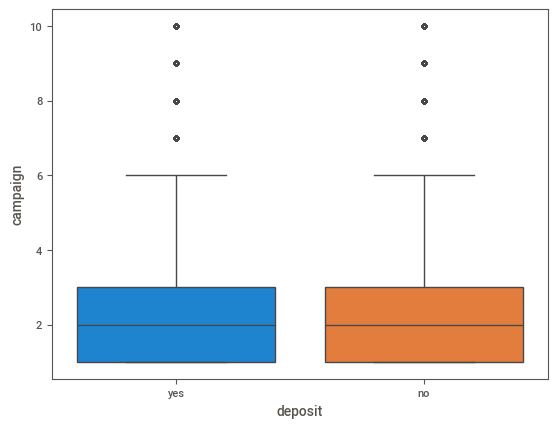

In [408]:
# Defining data groups
from scipy import stats
cols = ['campaign']
df1 = df.loc[df['campaign'] =='yes', cols]
df2 = df.loc[df['campaign'] =='no', cols] 
# Conduct the Mann-Whitney U Test 
result = stats.mannwhitneyu(df1, df2)
# Print the result
print(result)
# Vull visualitzar els boxplots de previous a cada categoria de deposit
# create grouped boxplot  
sns.boxplot(x = df['deposit'], 
            y = df['campaign'], 
            hue = df['deposit'])


## Associació bivariant entre target deposit i factors
### poutcome

Definiré un factor binari 'success' vs 'other'

deposit     no   yes
poutcome            
failure    610   618
other      230   307
success     93   978
unknown   4940  3386
deposit         no       yes
poutcome                    
failure   0.496743  0.503257
other     0.428305  0.571695
success   0.086835  0.913165
unknown   0.593322  0.406678
deposit         no       yes
poutcome                    
failure   0.103865  0.116846
other     0.039162  0.058045
success   0.015835  0.184912
unknown   0.841137  0.640197
The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are: 1004.635780185333 3 1.7761850102620281e-217


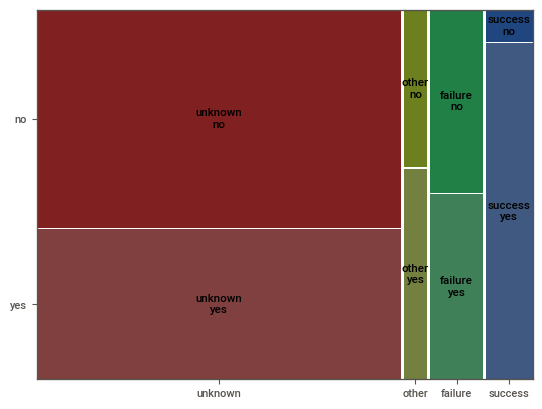

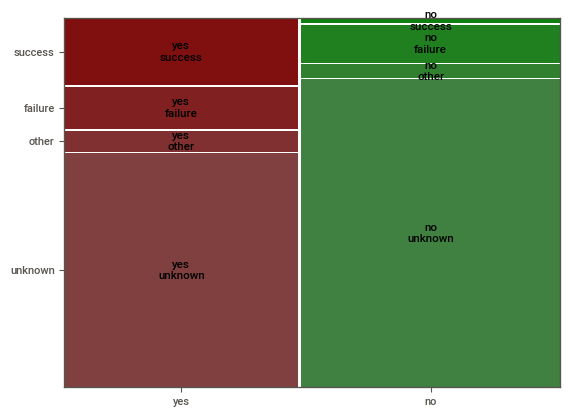

In [410]:
CrosstabResult = pd.crosstab(index=df['poutcome'], columns=df['deposit'])
print(CrosstabResult)
CrosstabRows = pd.crosstab(index=df['poutcome'], columns=df['deposit'], normalize="index")
print(CrosstabRows)
CrosstabCols = pd.crosstab(index=df['poutcome'], columns=df['deposit'], normalize="columns")
print(CrosstabCols)

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['poutcome', 'deposit'])
mosaic(df, [ 'deposit', 'poutcome'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

Clarament els qui van contractar en una campanya anterior un dipòsit, tenen una probabilitat per sobre el 90% de contractar-ne un altre a la campanya actual, tantmateix si no van contractar-lo no afecta a la situació actual, però si són nous en les campanyes, aleshores és una mica inferior la probabilitat de contractar.

### contact

Definiré el factor amb 3 nivells cellular, telephone i unknown

deposit      no   yes
contact              
cellular   3673  4369
telephone   384   390
unknown    1816   530
deposit          no       yes
contact                      
cellular   0.456727  0.543273
telephone  0.496124  0.503876
unknown    0.774084  0.225916
deposit          no       yes
contact                      
cellular   0.625404  0.826054
telephone  0.065384  0.073738
unknown    0.309212  0.100208
The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are: 736.6866796046972 2 1.0728032438445805e-160


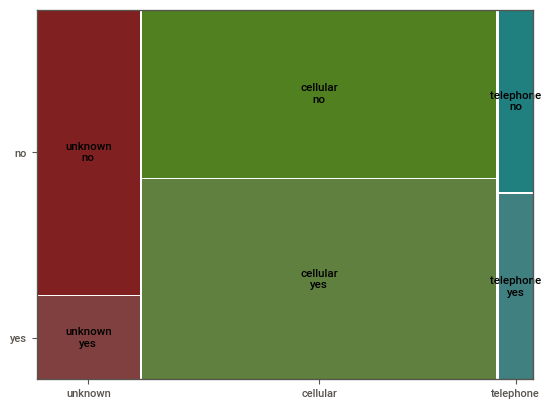

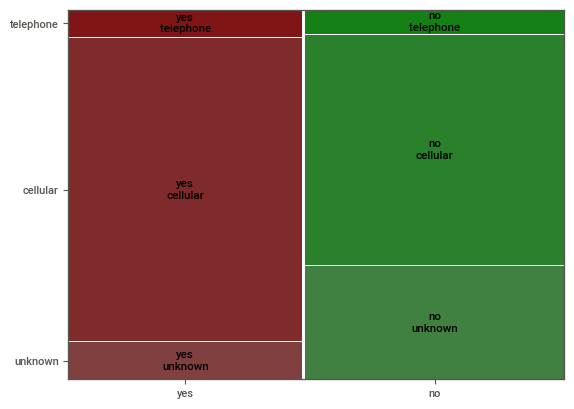

In [412]:
CrosstabResult = pd.crosstab(index=df['contact'], columns=df['deposit'])
print(CrosstabResult)
CrosstabRows = pd.crosstab(index=df['contact'], columns=df['deposit'], normalize="index")
print(CrosstabRows)
CrosstabCols = pd.crosstab(index=df['contact'], columns=df['deposit'], normalize="columns")
print(CrosstabCols)

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['contact', 'deposit'])
mosaic(df, [ 'deposit', 'contact'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

### housing and loan

Les persones amb hipoteques (housing) són incideixen negativament en la probabilitat de contractació i el mateix passa amb altres prèstecs (loan) però amb menor intensitat.

deposit    no   yes
housing            
no       2527  3354
yes      3346  1935
deposit        no       yes
housing                    
no       0.429689  0.570311
yes      0.633592  0.366408
deposit        no       yes
housing                    
no       0.430274  0.634146
yes      0.569726  0.365854
The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are: 463.1892407533161 1 9.724394114495535e-103
The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are: 463.1892407533161 1 9.724394114495535e-103


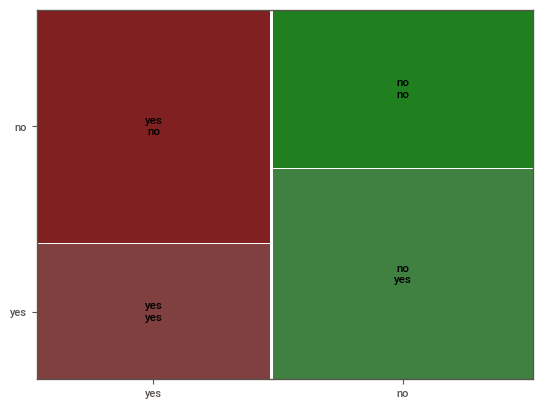

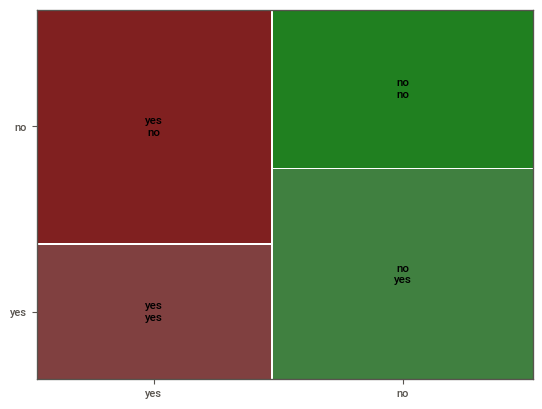

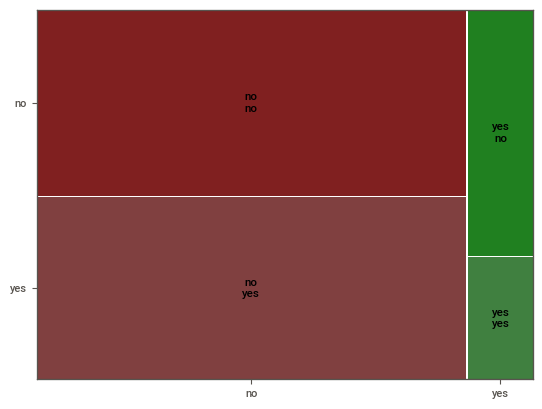

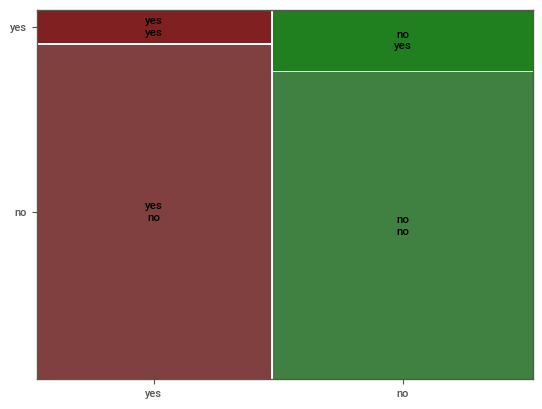

In [414]:
CrosstabResult = pd.crosstab(index=df['housing'], columns=df['deposit'])
print(CrosstabResult)
CrosstabRows = pd.crosstab(index=df['housing'], columns=df['deposit'], normalize="index")
print(CrosstabRows)
CrosstabCols = pd.crosstab(index=df['housing'], columns=df['deposit'], normalize="columns")
print(CrosstabCols)

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['housing', 'deposit'])
mosaic(df, [ 'deposit', 'housing'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['loan', 'deposit'])
mosaic(df, [ 'deposit', 'loan'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

### Marital status
Hi ha una clara diferència entre els casats i la resta, curiosament divorciats i solters tenen un comportament semblant. Per tant definiré un factor gmarital binari 'married' vs 'other'.

deposit     no   yes
marital             
divorced   671   620
married   3594  2755
single    1606  1911
unknown      2     3
deposit         no       yes
marital                     
divorced  0.519752  0.480248
married   0.566073  0.433927
single    0.456639  0.543361
unknown   0.400000  0.600000
deposit         no       yes
marital                     
divorced  0.114252  0.117224
married   0.611953  0.520892
single    0.273455  0.361316
unknown   0.000341  0.000567
The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are: 109.28002543010822 3 1.5677449862744508e-23


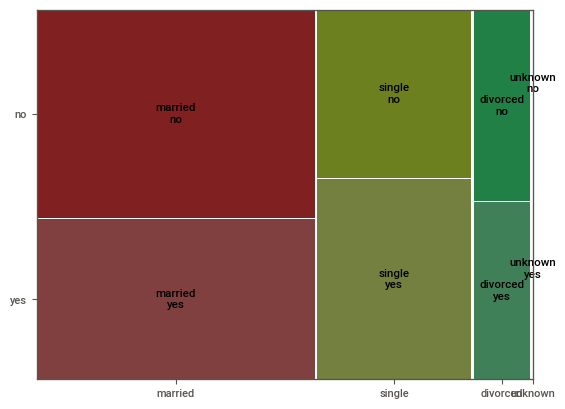

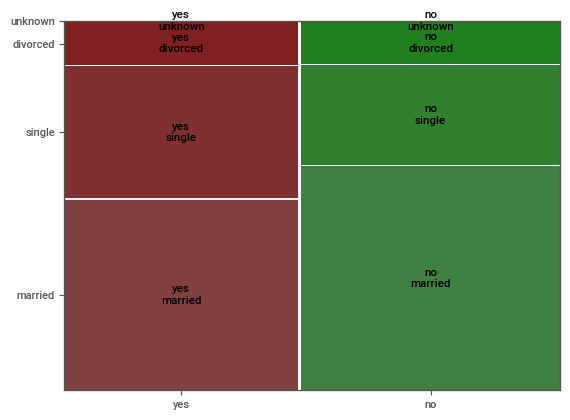

In [416]:
CrosstabResult = pd.crosstab(index=df['marital'], columns=df['deposit'])
print(CrosstabResult)
CrosstabRows = pd.crosstab(index=df['marital'], columns=df['deposit'], normalize="index")
print(CrosstabRows)
CrosstabCols = pd.crosstab(index=df['marital'], columns=df['deposit'], normalize="columns")
print(CrosstabCols)

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['marital', 'deposit'])
mosaic(df, [ 'deposit', 'marital'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

### month

Hi ha mesos molt diferents dels altres: mar, sep, oct i dec. Faré una variable binària pre-post vacances (sense gener).

deposit    no  yes
month             
apr       346  577
aug       831  688
dec        10  100
feb       335  441
jan       202  142
jul       887  627
jun       676  546
mar        28  248
may      1899  925
nov       540  403
oct        69  323
sep        50  269
deposit        no       yes
month                      
apr      0.374865  0.625135
aug      0.547070  0.452930
dec      0.090909  0.909091
feb      0.431701  0.568299
jan      0.587209  0.412791
jul      0.585865  0.414135
jun      0.553191  0.446809
mar      0.101449  0.898551
may      0.672450  0.327550
nov      0.572641  0.427359
oct      0.176020  0.823980
sep      0.156740  0.843260
deposit        no       yes
month                      
apr      0.058914  0.109094
aug      0.141495  0.130081
dec      0.001703  0.018907
feb      0.057041  0.083381
jan      0.034395  0.026848
jul      0.151030  0.118548
jun      0.115103  0.103233
mar      0.004768  0.046890
may      0.323344  0.174891
nov      0.091946  0.076196
oct   

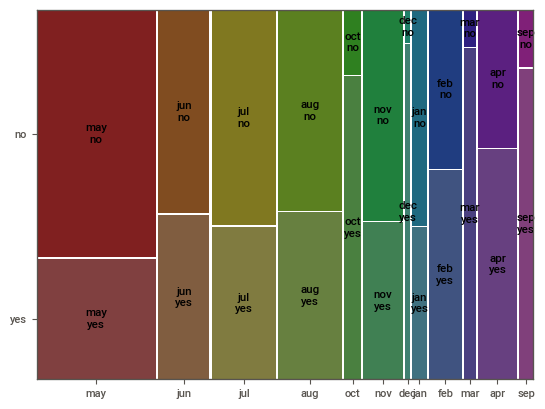

In [418]:
CrosstabResult = pd.crosstab(index=df['month'], columns=df['deposit'])
print(CrosstabResult)
CrosstabRows = pd.crosstab(index=df['month'], columns=df['deposit'], normalize="index")
print(CrosstabRows)
CrosstabCols = pd.crosstab(index=df['month'], columns=df['deposit'], normalize="columns")
print(CrosstabCols)

# Mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['month', 'deposit'])
# importing the required function
from scipy.stats import chi2_contingency
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The Chisq Stat, degrees of freedom and P-Value of the ChiSq Test are:', ChiSqResult[0], ChiSqResult[2], ChiSqResult[1])

# Conclusions EDA

Després de l'EDA univariant and bivariant (perfilar target) es té una comprensió més fina de les característiques del dataset.
Les variables numériques que consideraré són balance, age, campaign. La resta no com pdays no l'acabo de veure pels valors negatius quan no hi ha hagut contactes anteriors. Duration tampoc no s'ha usar, doncs és determinant de la resposta negativa en el cas de 0.

Defineixo abans de fer la partició de la mostra en treball i test les agrupacions dels factors:

    -gpoutcome: 'success' vs 'other'
    -gmarital: 'married' vs 'other'
    -gmonth: 'mar-sep-oct-dec' vs 'other'

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
marital
married     6349
single      3517
divorced    1291
unknown        5
Name: count, dtype: int64
education
secondary    5474
tertiary     3685
primary      1500
unknown       503
Name: count, dtype: int64
default
no     10994
yes      168
Name: count, dtype: int64
housing
no     5881
yes    5281
Name: count, dtype: int64
loan
no     9702
yes    1460
Name: count, dtype: int64
contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64
month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64
poutcome
unknown    8326
failure    1228
success    1071
ot

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
gjob         0
gpoutcome    0
gmonth       0
gmarital     0
age2         0
dtype: int64

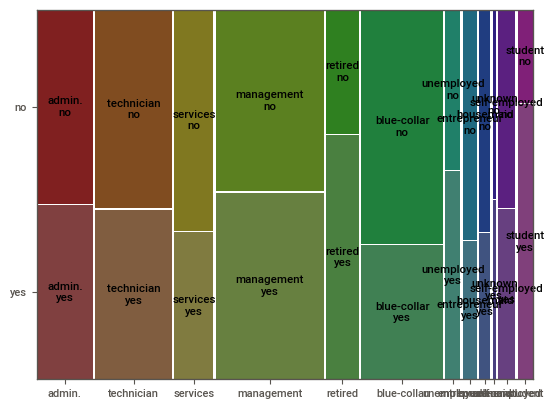

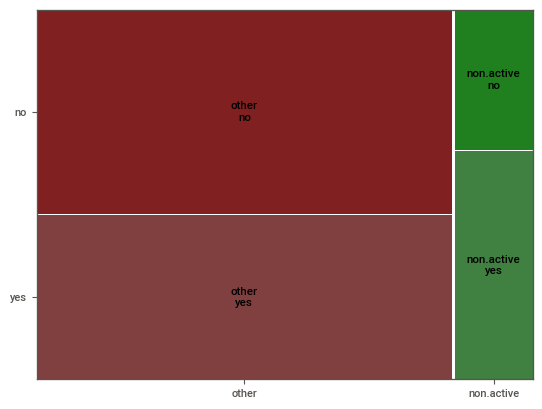

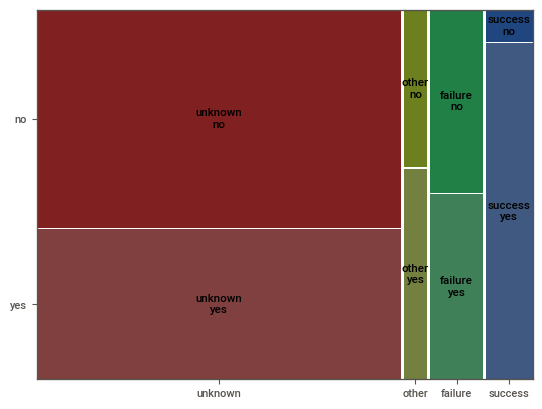

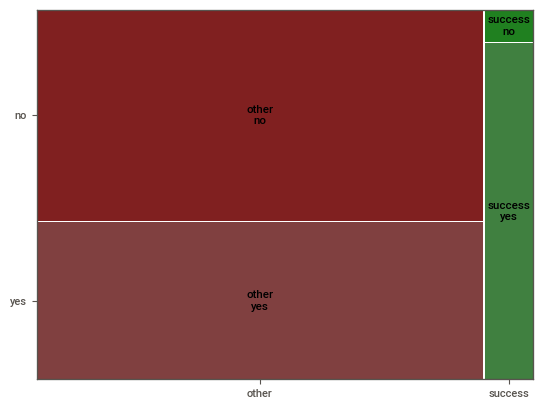

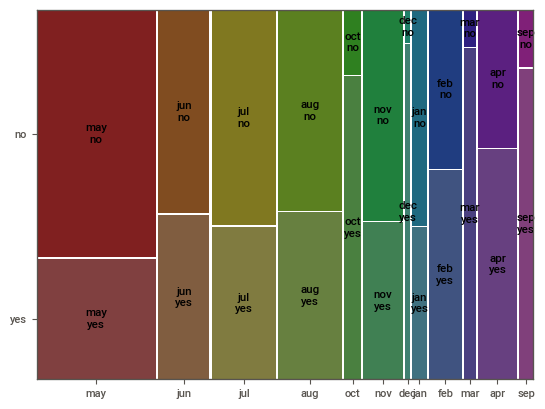

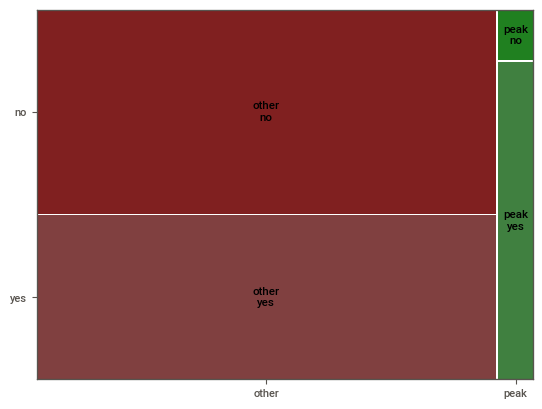

In [421]:
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['job', 'deposit'])
# Definir la qualitativa gjob 
df['gjob'] = ''
df.gjob =  np.where( df['job'].isin(["student","retired","unemployed","housemaid"]),    "non.active",  df.gjob )
df.gjob =  np.where( df['gjob'].isin(["","unknown"]), "other",   df.gjob )

for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts())
mosaic(df, ['gjob', 'deposit'])

# poutcome
mosaic(df, ['poutcome', 'deposit'])
df['gpoutcome'] = 'other'
df.gpoutcome =  np.where( df['poutcome'].isin(["success"]),    "success",    df.gpoutcome ) 
mosaic(df, ['gpoutcome', 'deposit'])

# month
mosaic(df, ['month', 'deposit'])
df['gmonth'] = ''
df.gmonth =  np.where( df['month'].isin(["mar","set","oct","dec"]),    "peak",    df.gmonth ) 
df.gmonth =  np.where( df['gmonth'].isin([""]), "other",   df.gmonth )
mosaic(df, ['gmonth', 'deposit'])

# marital
df['gmarital'] = 'other'
df.gmarital =  np.where( df['marital'].isin(["married"]), "married",   df.gmarital )
print("df", df.shape)

df['age2'] = df['age']*df['age']

df.to_csv('AfterEDA.csv', index=False)
df.isnull().sum()

# Preparació de les mostres de treball i de test (Tasca 6.1). Estratificació segons el target

In [423]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Dividir el dataset en conjunts de treball i test 75-25 Estratificat pel target diposit
train, test = train_test_split(df, test_size=0.25, random_state=28061963, stratify=df['deposit'])
tr = train.groupby('deposit').count()
tst = test.groupby('deposit').count()
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
print("Tamany del conjunt de treball (train):", train.shape)
print("Tamany del conjunt de test (test):", test.shape)
# compare the dataset amb Sweetviz
compare = sv.compare(source=train, compare=test, target_feat="deposit")
# Show the result
compare.show_html('Compare.html')

Tamany del conjunt de treball (train): (8371, 22)
Tamany del conjunt de test (test): (2791, 22)


                                             |          | [  0%]   00:00 -> (? left)

Report Compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Correlació entre numèriques a la mostra test per prevenir la multicolinearitat

La correlació més elevada és de 0.54 entre previous i pdays a la working sample (0.49 a la test sample). La correlació entre la resta de parelles de variables és desestimable.

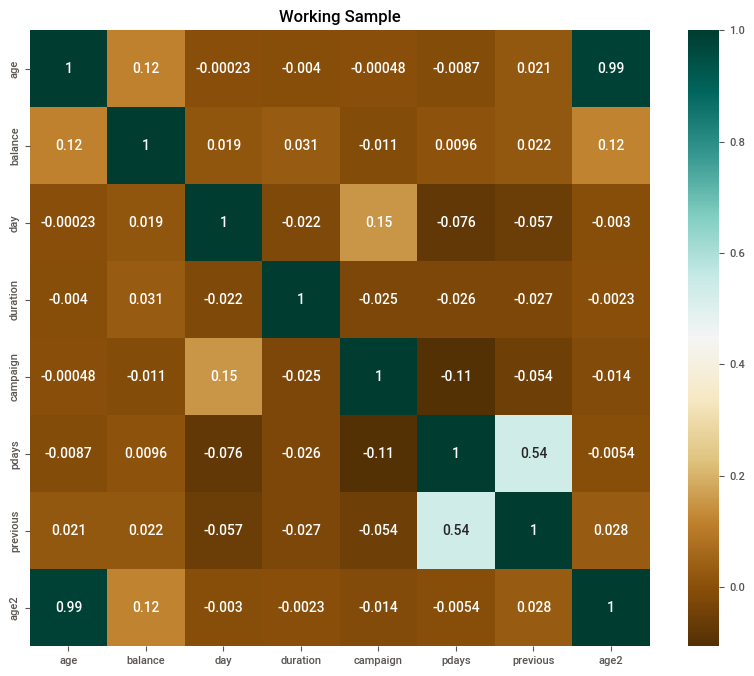

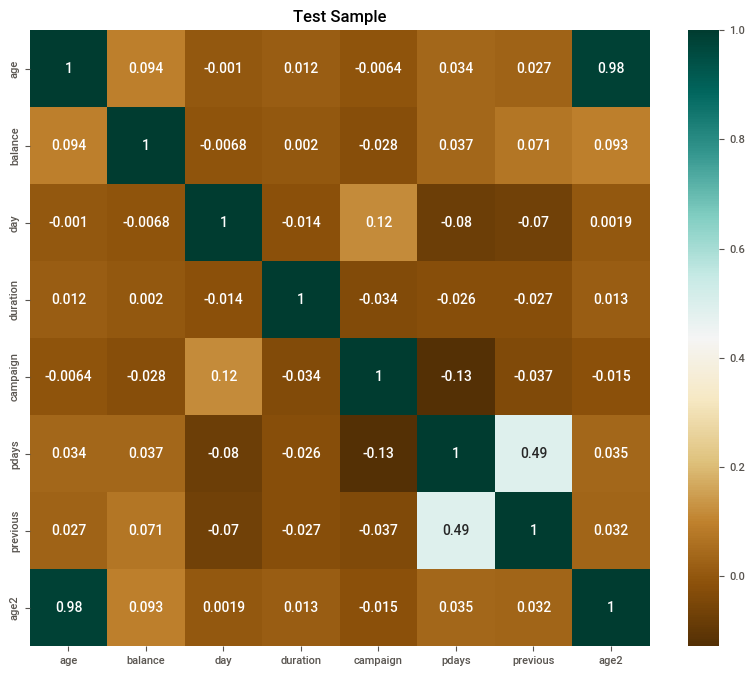

In [425]:
# Filtrar les columnes numèriques de la mostra de treball
train_numeric = train.select_dtypes(include=['number'])
train_factor = train.select_dtypes(include=['object'])
# Correlació entre les variables numèriques de la working sample
wcorr_matrix = train_numeric.corr()
# Pintar el heatmap amb les correlacions entre numèriques de la mostra de treball
plt.figure(figsize=(10, 8))
sns.heatmap(wcorr_matrix, annot=True, cmap='BrBG').set_title('Working Sample')
plt.show()

# Correlació entre les variables numèriques de la test sample
test_numeric = test.select_dtypes(include=['number'])
test_factor = test.select_dtypes(include=['object'])
tcorr_matrix = test_numeric.corr()
# Pintar el heatmap amb les correlacions entre numèriques de la mostra de treball
plt.figure(figsize=(10, 8))
sns.heatmap(tcorr_matrix, annot=True, cmap='BrBG').set_title('Test Sample')
plt.show()
# La correlació més elevada és de 0.52 entre previous i pdays. La correlació entre la resta de parelles de variables és desestimable.

## Estandardització
**Ho evitaré el màxim de temps que pugui doncs perdo la possibilitat de fer una interpretació directa del estimadors del model de regressió logística** que aplicaré. Sé que no és el que suggereix el curs, però personalment ho evito; més tard podria repetir l'exercici amb estandardització. Ara no escalo res.

In [427]:
# Especificar las columnas numéricas a estandarizar al working set. Day no té sentit. Pdays i previous tenen un munt de zeros
#train_num_scaled = train_numeric
#colsnum = train_num_scaled.select_dtypes(include=["number"]).columns.tolist()
#print("Llista de columnes numèriques:", colsnum)
#cols2Stand = ['age', 'balance','campaign']
#sccols2Stand = ['scage', 'scbalance','sccampaign']
#scaler = StandardScaler() # Inicialitzar l'escalat standard
#train_num_scaled[sccols2Stand] = scaler.fit_transform(train_num_scaled[cols2Stand])
#train_num_scaled.describe()
#print("Train Scaled", train_num_scaled.shape)
#train_scaled = pd.concat([train_num_scaled,train_factor], axis=1)
#print("Train Scaled", train_scaled.shape)
#train_scaled.to_csv('escalat_train.csv', index=False)
#train_scaled.isnull().sum()

In [428]:
# Especificar las columnas numéricas a estandarizar al test set. Day no té sentit. Pdays i previous tenen un munt de zeros
#test_num_scaled = test_numeric

#test_num_scaled[sccols2Stand] = scaler.transform(test_num_scaled[cols2Stand]) # Comentari 3 Verònica
#test_scaled = pd.concat([test_num_scaled,test_factor], axis=1)
#test_scaled.to_csv('escalat_test.csv', index=False)
#test_scaled.describe()
#test_scaled.isnull().sum()

## Label Encoding vs. One-Hot Encoding

**Reducció del nombre de categories de les variables qualitatives (factors) a considerar ja efectuada.**

La definició de les dummies la puc fer directament i només per les variables a considerar. Faig manualment el One-Hot Encoding, poso davant la lletra d per diferenciar que són dummies relacionades amb els factors.



In [430]:
for column in train.select_dtypes(include=['object']).columns:
    print(train[column].value_counts())
    
train['dhousing'] = train['housing'].map({'no': 0, 'yes': 1})
train['dloan'] = train['loan'].map({'no': 0, 'yes': 1})
train['dgpoutcome'] = train['gpoutcome'].map({'other': 0, 'success': 1})
train['dgmarital'] = train['gmarital'].map({'other': 0, 'married': 1})
train['dgmonth'] = train['gmonth'].map({'other': 0, 'peak': 1})
train['dcontact.cel'] = train['contact'].map({'telephone': 0, 'unknown':0, 'cellular': 1})
train['dcontact.tel'] = train['contact'].map({'telephone': 1, 'unknown':0, 'cellular': 0})
train.head()
train.to_csv('train_dum.csv', index=False)
train.isnull().sum()

job
management       1923
blue-collar      1503
technician       1347
admin.            963
services          690
retired           594
self-employed     302
unemployed        275
student           270
entrepreneur      245
housemaid         210
unknown            49
Name: count, dtype: int64
marital
married     4814
single      2589
divorced     964
unknown        4
Name: count, dtype: int64
education
secondary    4107
tertiary     2757
primary      1136
unknown       371
Name: count, dtype: int64
default
no     8239
yes     132
Name: count, dtype: int64
housing
no     4398
yes    3973
Name: count, dtype: int64
loan
no     7296
yes    1075
Name: count, dtype: int64
contact
cellular     6005
unknown      1777
telephone     589
Name: count, dtype: int64
month
may    2144
jul    1121
aug    1103
jun     914
apr     720
nov     715
feb     586
oct     284
jan     257
sep     238
mar     208
dec      81
Name: count, dtype: int64
poutcome
unknown    6287
failure     904
success     788
othe

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
deposit         0
gjob            0
gpoutcome       0
gmonth          0
gmarital        0
age2            0
dhousing        0
dloan           0
dgpoutcome      0
dgmarital       0
dgmonth         0
dcontact.cel    0
dcontact.tel    0
dtype: int64

## Reducció de la dimensionalitat en numèriques no és necessària pel limitat nombre de numèriques

## Aplicar la definició de noves categòriques a la mostra test

In [433]:
test['dhousing'] = test['housing'].map({'no': 0, 'yes': 1})
test['dloan'] = test['loan'].map({'no': 0, 'yes': 1})
test['dgpoutcome'] = test['gpoutcome'].map({'other': 0, 'success': 1})
test['dgmarital'] = test['gmarital'].map({'other': 0, 'married': 1})
test['dgmonth'] = test['gmonth'].map({'other': 0, 'peak': 1})
test['dcontact.cel'] = test['contact'].map({'telephone': 0, 'unknown':0, 'cellular': 1})
test['dcontact.tel'] = test['contact'].map({'telephone': 1, 'unknown':0, 'cellular': 0})
test.head()

test.to_csv('test_dum.csv', index=False)
test.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
deposit         0
gjob            0
gpoutcome       0
gmonth          0
gmarital        0
age2            0
dhousing        0
dloan           0
dgpoutcome      0
dgmarital       0
dgmonth         0
dcontact.cel    0
dcontact.tel    0
dtype: int64

# Model Regressió Logística

In [435]:
columnes = train.columns.tolist()
print( columnes )
train.describe()
train.isnull().sum()

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'gjob', 'gpoutcome', 'gmonth', 'gmarital', 'age2', 'dhousing', 'dloan', 'dgpoutcome', 'dgmarital', 'dgmonth', 'dcontact.cel', 'dcontact.tel']


age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
deposit         0
gjob            0
gpoutcome       0
gmonth          0
gmarital        0
age2            0
dhousing        0
dloan           0
dgpoutcome      0
dgmarital       0
dgmonth         0
dcontact.cel    0
dcontact.tel    0
dtype: int64

In [436]:
# Especificar las columnas para características y variable objetivo
# import the class
from numpy import mean
from numpy import std
from scipy.stats import sem
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

columnes = train.columns.tolist()
#['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'gjob', 'gpoutcome', 'gmonth', 'gmarital', 
# 'dhousing', 'dloan', 'dgpoutcome', 'dgmarital', 'dgmonth', 'dcontact.cel', 'dcontact.tel']
feature_columns = ['balance', 'age', 'campaign','dgpoutcome','dhousing','dloan','dgmarital','dgmonth','dcontact.cel', 'dcontact.tel']
target_column = 'deposit'

# Separar características (X) y variable objetivo (y) en el conjunto de entrenamiento
X_train = train[feature_columns]
y_train = train[target_column]

X_train.describe()
# Separar características (X) y variable objetivo (y) en el conjunto de prueba
X_test = test[feature_columns]
y_test = test[target_column]

# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Mean Accuracy and StError: %.3f (%.3f)' % (mean(scores), std(scores)))
# Dolent: 0.69 amb una error standard del 1.9%
print('Accuracy per Fold:',scores)
X_train.describe()

Mean Accuracy and StError: 0.681 (0.019)
Accuracy per Fold: [0.66706444 0.66188769 0.67383513 0.67502987 0.69414576 0.70489845
 0.64874552 0.71565114 0.69175627 0.67383513]


,balance,age,campaign,dgpoutcome,dhousing,dloan,dgmarital,dgmonth,dcontact.cel,dcontact.tel
count,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000
mean,1540.724406,41.226257,2.401864,0.094135,0.474615,0.128420,0.575081,0.068451,0.717358,0.070362
std,3020.023675,11.890377,1.996416,0.292033,0.499385,0.334576,0.494360,0.252533,0.450311,0.255771
min,-4636.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,123.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550.000000,39.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1745.000000,49.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,40000.000000,95.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Aplicar a la mostra de treball completa l'estimació del model

In [438]:
# create model
# instantiate the model (using the default parameters)
model = LogisticRegression()

# fit the model with data
model.fit(X_train, y_train)

FloatingPointError: underflow encountered in divide

In [ ]:
y_pred = model.predict(X_train)

# Matriu de confusió
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
print( cnf_matrix )

# Report de classificació
target_names = ['No', 'Yes']
print(classification_report(y_train, y_pred, target_names=target_names))

# Area sota la corba ROC
y_pred_proba = model.predict_proba(X_train)[::,1]
print( model.predict_proba(X_train) )
auc = metrics.roc_auc_score(y_train, y_pred_proba)
print('AUC:', auc)

#fpr, tpr,_ = roc_curve(y_train,  y_pred_proba)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# axis labels
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
# show the legend
#plt.legend(loc=4)
# show the plot
#plt.show()

## Aplicar el model a la mostra de test: No executa perquè no he pogut estimar el model amb pandas

In [ ]:
y_pred = model.predict(X_test)

# Matriu de confusió
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print( cnf_matrix )

# Report de classificació
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred, target_names=target_names))

# Area sota la corba ROC
y_pred_proba = model.predict_proba(X_test)[::,1]
print( model.predict_proba(X_test) )
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc)

#fpr, tpr,_ = roc_curve(y_test,  y_pred_proba)
#plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# axis labels
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
# show the legend
#plt.legend(loc=4)
# show the plot
#plt.show()

El model no puc fer-lo funcionar. En RStudio no té problemes.

Per altra banda no trobo una manera àgil de poder fer inferència per comparar dos models encaixats (nested), trobo molt laboriosa la feina de construcció de models. El tema de les dummies que no es creen per defecte també és farragós. Com a usuària d'RStudio ... se'm fa difícil veure-li les avantatges al pandas.

El model en RStudio té un R2 McFadden de 0.158 (dolent), totes les variables són significatives. L'àrea sota la corba ROC és 0.75 (ni bo, ni dolent) i l'accuracy és 0.695 (fa bones prediccions de positius i negatius en 70% dels casos, consistent amb la Kappa de Cohen 0.38). En la mostra test l'accuracy baixa 3 punts (67%).

El balance afecta positivament a la probabilitat de contractar un dipòsit, cada 1000$ incrementen els odds de la probabilitat de contractar en un 4.5% i per cada trucada de més a la campanya actuals els odds de contractar disminueixen en un 9%. Tenir un prèstec (loan o housing) té un efecte negatiu en la contractació redueix en un 32-33% els odds de la probabilitat de contractació.

Call:
glm(formula = deposit ~ balance + age + I(age^2) + campaign + 
    gpoutcome + contact + housing + loan + gmarital + gmonth, 
    family = binomial, data = dfw)

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.773e+00  3.062e-01   5.791 6.99e-09 
balance                4.433e-05  8.903e-06   4.979 6.39e-07 
age                   -1.103e-01  1.392e-02  -7.926 2.25e-15 
I(age^2)               1.208e-03  1.519e-04   7.954 1.80e-15 
campaign              -9.467e-02  1.305e-02  -7.256 4.00e-13 
gpoutcomesuccess       2.056e+00  1.264e-01  16.271  < 2e-16 
contacttelephone       5.436e-01  1.165e-01   4.665 3.09e-06 
contactcellular        9.275e-01  6.609e-02  14.033  < 2e-16 
housingyes            -4.071e-01  5.129e-02  -7.936 2.09e-15 
loanyes               -3.893e-01  7.429e-02  -5.240 1.60e-07 
gmaritalmarried       -2.620e-01  5.287e-02  -4.955 7.23e-07 
gmonthmar-sep-oct-dec  1.408e+00  1.049e-01  13.425  < 2e-16 
---


(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11577.8  on 8371  degrees of freedom
Residual deviance:  9743.3  on 8360  degrees of freedom
AIC: 9767.3

Number of Fisher Scoring iterations: 5

> Anova(m4,test="LR")
Analysis of Deviance Table (Type II tests)

Response: deposit
          LR Chisq Df Pr(>Chisq)    
balance      25.98  1  3.446e-07 ***
age          67.54  1  < 2.2e-16 ***
I(age^2)     69.77  1  < 2.2e-16 ***
campaign     55.19  1  1.095e-13 ***
gpoutcome   391.71  1  < 2.2e-16 ***
contact     216.71  2  < 2.2e-16 ***
housing      62.93  1  2.139e-15 ***
loan         28.15  1  1.124e-07 ***
gmarital     24.54  1  7.293e-07 ***
gmonth      215.89  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Confusion Matrix and Statistics WORK SAMPLE

          Reference
Prediction   no  yes
       no  3626 1752
       yes  803 2191
                                          
               Accuracy : 0.6948          
                 95% CI : (0.6848, 0.7047)
    No Information Rate : 0.529           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3794          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8187          
            Specificity : 0.5557          
         Pos Pred Value : 0.6742          
         Neg Pred Value : 0.7318          
             Prevalence : 0.5290          
         Detection Rate : 0.4331          
   Detection Prevalence : 0.6424          
      Balanced Accuracy : 0.6872          
                                          
       'Positive' Class : no              

# Gràcies pel feedback donat !